In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 221 (delta 108), reused 197 (delta 91), pack-reused 0
Receiving objects: 100% (221/221), 64.85 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (108/108), done.


---

In [1]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/DaLiAc'

In [2]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import SDReader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-2-13219c341a77>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [4]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "SOTAEmbedding",
    "model_params":{
        "linear_filters":[1024,1024,1024,400],
        "input_feat":48,
        "dropout":0.1,
    },
    "folding": True,
    "lr": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 32,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [5]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [6]:
IMU_data_path = data_root+'/IMU/'
dataReader = SDReader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 19
Reading file 2 of 19
Reading file 3 of 19
Reading file 4 of 19
Reading file 5 of 19
Reading file 6 of 19
Reading file 7 of 19
Reading file 8 of 19
Reading file 9 of 19
Reading file 10 of 19
Reading file 11 of 19
Reading file 12 of 19
Reading file 13 of 19
Reading file 14 of 19
Reading file 15 of 19
Reading file 16 of 19
Reading file 17 of 19
Reading file 18 of 19
Reading file 19 of 19


/content/src/datasets/data.py:2092: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [7]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [8]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [9]:
video_feat.shape

(12, 400)

In [10]:
vid_cls_name = np.unique(video_classes)

In [11]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [12]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048],input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [13]:
# model = SOTAEmbedding(
#     linear_filters=config["model_params"]["linear_filters"],
#     input_feat=config["model_params"]["input_feat"],
#     dropout=config["model_params"]["dropout"]
# )

# emb = model(torch.randn((32,36)))
# emb.size()

---

In [14]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# run 5-fold running
fold_classes = [['sitting', 'vacuuming', 'descending stairs'], ['lying', 'sweeping', 'treadmill running'], ['standing', 'walking', 'cycling'], ['washing dishes', 'ascending stairs', 'rope jumping']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [16]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [17]:
selecting_video_prototypes(video_feat,video_classes,vid_cls_name).shape

torch.Size([12, 400])

In [18]:
dataReader.label_map

[(1, 'sitting'),
 (2, 'lying'),
 (3, 'standing'),
 (4, 'washing dishes'),
 (5, 'vacuuming'),
 (6, 'sweeping'),
 (7, 'walking'),
 (8, 'ascending stairs'),
 (9, 'descending stairs'),
 (10, 'treadmill running'),
 (11, 'cycling'),
 (12, 'rope jumping')]

In [19]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [20]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

In [21]:
data_dict['train']['X'].shape,data_dict['eval-seen']['X'].shape,data_dict["test"]["X"].shape

((64424, 48), (16106, 48), (11808, 48))

In [22]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [23]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [32]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=False)
    metrics_dict.update(metrics)
    return metrics_dict

In [25]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [26]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

================ Fold-0 ================
Unseen Classes : ['sitting', 'vacuuming', 'descending stairs']
seen classes >  [1, 2, 3, 5, 6, 7, 9, 10, 11]
unseen classes >  [0, 4, 8]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.970



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.981



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.986



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.987



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.989



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.989



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.990



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.991



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.990



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.991



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.991



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.991



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.993



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.992



train:   0%|          | 0/988 [00:00<?, ?batch/s]

seen:   0%|          | 0/247 [00:00<?, ?batch/s]

Overall accuracy: 0.993



unseen:   0%|          | 0/177 [00:00<?, ?batch/s]

Overall accuracy: 0.937

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        vacuuming       0.885      0.963      0.922      0.389       2201|	 descending stairs: 0.019,	sitting: 0.019,	
          sitting       0.982      0.994      0.988      0.387       2193|	 vacuuming: 0.006,	descending stairs: 0.000,	
descending stairs       0.961      0.794      0.870      0.224       1270|	 vacuuming: 0.206,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.939      0.937      0.936        1.0       5664|	      

{'accuracy': 0.9369703389830508, 'precision': 0.9425378009588536, 'recall': 0.9169494824088416, 'f1': 0.9265570881690864, 'samples': 5664, 'loss': 3031771.7734375, 'feat. loss': 3031771.427734375, 'classi. loss': 3691.809513092041}
================ Fold-1 ================
Unseen Classes : ['lying', 'sweeping', 'treadmill running']
seen classes 

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.913



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.918



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.960



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.979



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.982



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.987



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.986



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.986



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.986



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.989



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.989



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.991



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.991



train:   0%|          | 0/870 [00:00<?, ?batch/s]

seen:   0%|          | 0/217 [00:00<?, ?batch/s]

Overall accuracy: 0.991



unseen:   0%|          | 0/325 [00:00<?, ?batch/s]

Overall accuracy: 0.752

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

treadmill running       0.928      1.000      0.963      0.435       4522|	 sweeping: 0.000,	lying: 0.000,	
         sweeping       0.599      0.900      0.719      0.353       3669|	 treadmill running: 0.096,	lying: 0.004,	
            lying       0.000      0.000      0.000      0.212       2209|	 sweeping: 1.000,	treadmill running: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.615      0.752      0.672        1.0      10400|	      

{'accuracy': 0.7523076923076923, 'precision': 0.5090452517224257, 'recall': 0.6333242482056872, 'f1': 0.5606765600608801, 'samples': 10400, 'loss': 6004081.9921875, 'feat. loss': 6004081.34765625, 'classi. loss': 7861.733594894409}
================ Fold-2 ================
Unseen Classes : ['standing', 'walking', 'cycling']
seen classes >  [0, 1, 3, 4

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.824



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.921



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.964



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.967



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.972



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.972



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.976



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.977



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.978



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.982



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.981



train:   0%|          | 0/587 [00:00<?, ?batch/s]

seen:   0%|          | 0/146 [00:00<?, ?batch/s]

Overall accuracy: 0.983



unseen:   0%|          | 0/678 [00:00<?, ?batch/s]

Overall accuracy: 0.568

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    walking       0.555      0.994      0.712      0.470      10201|	 standing: 0.006,	cycling: 0.000,	
    cycling       0.000      0.000      0.000      0.429       9310|	 walking: 0.873,	standing: 0.127,	
   standing       0.637      1.000      0.778      0.101       2185|	 walking: 0.000,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
avg / total       0.325      0.568      0.413        1.0      21696|	      

{'accuracy': 0.5678005162241888, 'precision': 0.39730048492742603, 'recall': 0.6643574600566747, 'f1': 0.49673200282982427, 'samples': 21696, 'loss': 12138384.787109375, 'feat. loss': 12138382.59765625, 'classi. loss': 20368.79017829895}
================ Fold-3 ================
Unseen Classes : ['washing dishes', 'ascending stairs', 'rope jumping']
seen classes >  [0, 1, 2, 4, 5, 6, 8, 9, 10]
un

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.917



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.970



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.975



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.979



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.981



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.981



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.982



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.983



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.980



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.986



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.986



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.986



train:   0%|          | 0/945 [00:00<?, ?batch/s]

seen:   0%|          | 0/236 [00:00<?, ?batch/s]

Overall accuracy: 0.986



unseen:   0%|          | 0/231 [00:00<?, ?batch/s]

Overall accuracy: 0.854

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  washing dishes       1.000      0.931      0.964      0.631       4665|	 rope jumping: 0.069,	ascending stairs: 0.000,	
ascending stairs       0.991      0.506      0.670      0.204       1507|	 rope jumping: 0.494,	washing dishes: 0.000,	
    rope jumping       0.532      0.994      0.693      0.165       1220|	 ascending stairs: 0.006,	washing dishes: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.921      0.854      0.859        1.0       7392|	      

{'accuracy': 0.8544372294372294, 'precision': 0.8408161799986096, 'recall': 0.8101497546441943, 'f1': 0.7754555892659267, 'samples': 7392, 'loss': 5503912.1015625, 'feat. loss': 5503911.64453125, 'classi. loss': 6196.967767715454}
============== Overall Unseen Classes Performance ==============


accuracy        7.778789e-01
precision       6.724249e-01
recall          7.561952e-01
f1              6.898553e-01
samples         1.128800e+04
loss            6.669538e+06
feat. loss      6.669537e+06
classi. loss    9.529825e+03
dtype: float64

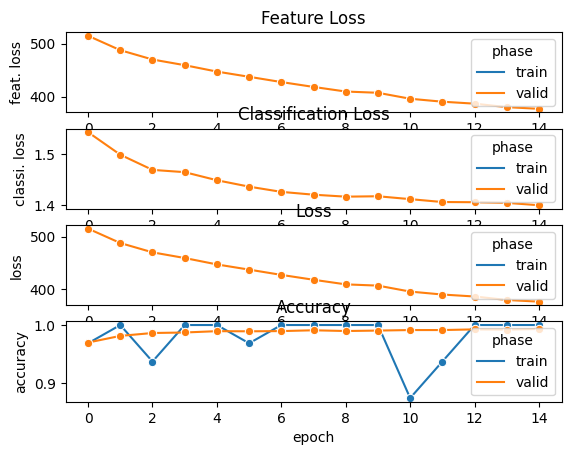

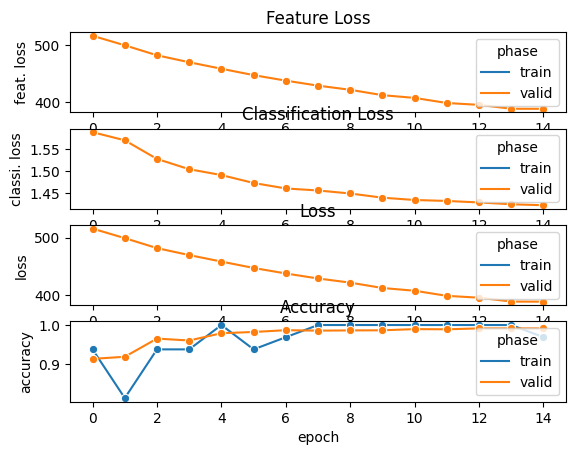

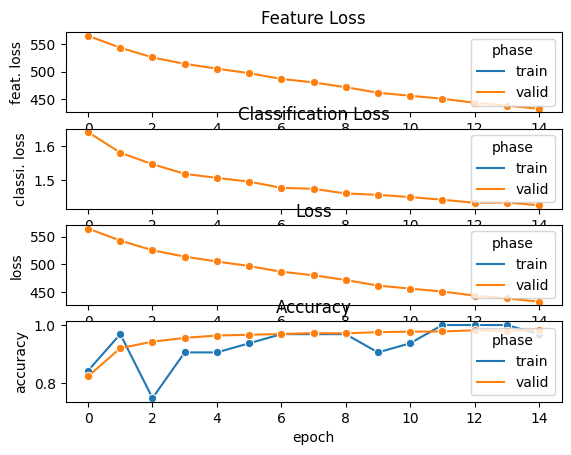

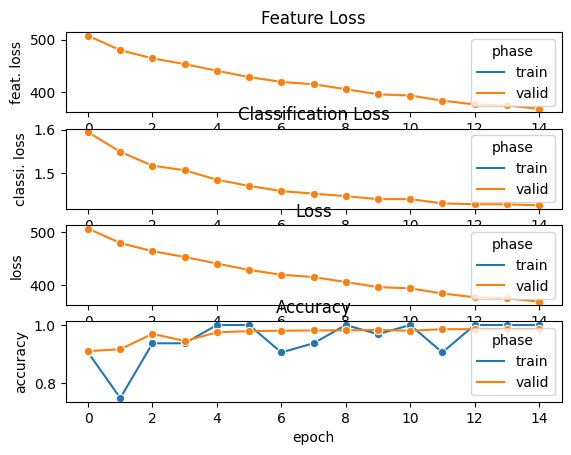

In [36]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    model.to(device)
    # define run parame
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
